Epoch 1/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 69s 197ms/step - loss: 0.0128 - mae: 0.0782 - val_loss: 0.0093 - val_mae: 0.0553
Epoch 2/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 82s 199ms/step - loss: 0.0029 - mae: 0.0365 - val_loss: 0.0055 - val_mae: 0.0452
Epoch 3/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 80s 191ms/step - loss: 0.0020 - mae: 0.0303 - val_loss: 3.3239e-04 - val_mae: 0.0127
Epoch 4/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 83s 195ms/step - loss: 0.0015 - mae: 0.0259 - val_loss: 4.1474e-04 - val_mae: 0.0137
Epoch 5/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 61s 195ms/step - loss: 0.0013 - mae: 0.0239 - val_loss: 1.5523e-04 - val_mae: 0.0083
Epoch 6/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 87s 212ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 1.6358e-04 - val_mae: 0.0086
Epoch 7/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 61s 196ms/step - loss: 0.0010 - mae: 0.0214 - val_loss: 5.5449e-04 - val_mae: 0.0157
Epoch 8/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 66s 212ms/step - loss: 0.0010 - mae: 0.0210 - val_loss: 1.8085e-04 - val_mae: 0.0095
Epoch 9/

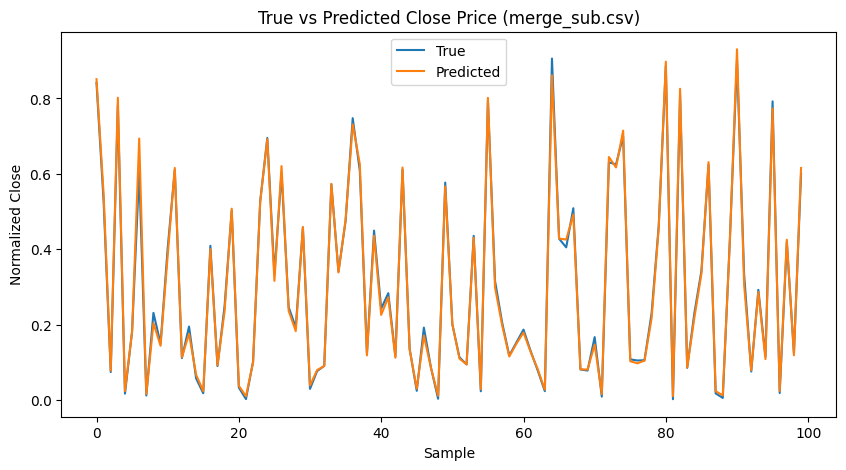

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, Add, BatchNormalization, Dropout, LSTM, MultiHeadAttention, LayerNormalization, Conv1DTranspose
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("/content/drive/MyDrive/Time series/top_10_stock_data.csv")

SEQ_LEN = 60
FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']
TARGET = 'Close'

def create_sequences(df, seq_len=60):
    X, y = [], []
    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values("Date")
        values = group[FEATURES].values
        if len(values) <= seq_len:
            continue
        scaler = MinMaxScaler()
        values_scaled = scaler.fit_transform(values)
        for i in range(len(values_scaled) - seq_len):
            X.append(values_scaled[i:i+seq_len])
            y.append(values_scaled[i+seq_len][FEATURES.index(TARGET)])
    return np.array(X), np.array(y).reshape(-1, 1)

X_all, y_all = create_sequences(df, seq_len=SEQ_LEN)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

def residual_cnn_block(inputs):
    x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(inputs)
    x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    shortcut = Conv1D(filters=64, kernel_size=1, padding="same")(inputs)
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)
    return x

def transformer_block(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn = Dropout(dropout)(attn)
    out1 = Add()([attn, inputs])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    ffn = Dense(ff_dim, activation='relu')(out1)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)
    out2 = Add()([ffn, out1])
    return LayerNormalization(epsilon=1e-6)(out2)

def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = residual_cnn_block(inputs)
    x = transformer_block(x)
    x = LSTM(64)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse", metrics=["mae"])
    return model

model = build_model(X_train.shape[1:])
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

direction_true = np.sign(y_test[1:] - y_test[:-1])
direction_pred = np.sign(y_pred[1:] - y_pred[:-1])
directional_accuracy = np.mean(direction_true == direction_pred) * 100

print(f"\n--- Evaluation Metrics ---")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label="True")
plt.plot(y_pred[:100], label="Predicted")
plt.title("True vs Predicted Close Price (merge_sub.csv)")
plt.xlabel("Sample")
plt.ylabel("Normalized Close")
plt.legend()
plt.show()


Shap generate

  0%|          | 0/50 [00:00<?, ?it/s]

shap_values shape: (50, 5)
X_explain shape: (50, 5)


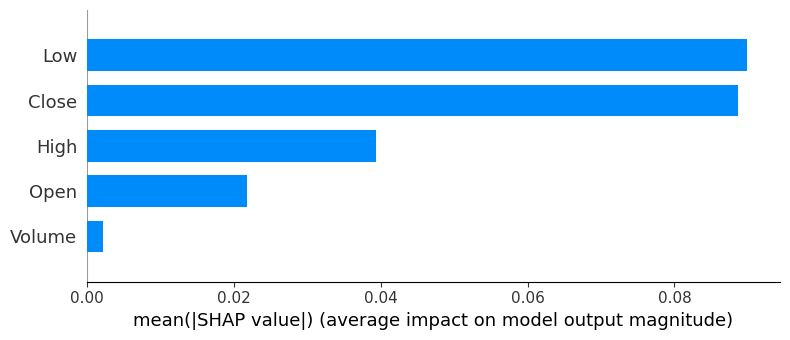

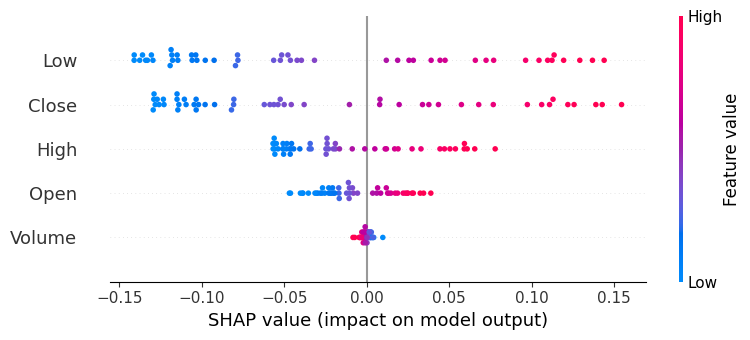

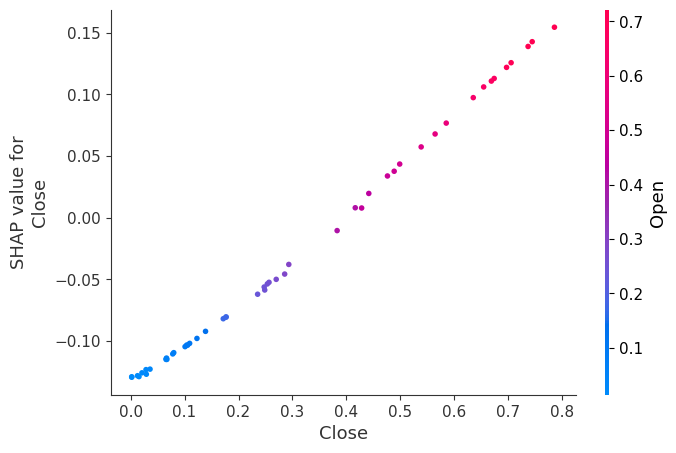

In [ ]:
import shap


X_train_agg = np.mean(X_train, axis=1)   # (n, 5)
X_test_agg  = np.mean(X_test, axis=1)    # (n, 5)

# Prediction wrapper for SHAP
def model_predict(x):
    x_seq = np.repeat(x[:, np.newaxis, :], SEQ_LEN, axis=1)  # back to (n, 60, 5)
    return model.predict(x_seq, verbose=0)

# Background & explain set
X_background = X_train_agg[:30]
X_explain    = X_test_agg[:50]


explainer = shap.KernelExplainer(model_predict, X_background)
shap_values = explainer.shap_values(X_explain, nsamples=100)

# Force into correct shape
# If KernelExplainer returns a list, take the first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Make sure it's numpy array (50, 5)
shap_values = np.array(shap_values)
print("shap_values shape:", shap_values.shape)
print("X_explain shape:", X_explain.shape)


shap.summary_plot(shap_values, X_explain, feature_names=FEATURES, plot_type="bar")
shap.summary_plot(shap_values, X_explain, feature_names=FEATURES)


# Step 4: SHAP Dependency Plot

shap.dependence_plot(3, shap_values, X_explain, feature_names=FEATURES)  # 3 = "Close"


# Step 5: SHAP Force Plot (single prediction)

shap.initjs()
idx = 5
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_explain[idx],
    feature_names=FEATURES
)


  0%|          | 0/50 [00:00<?, ?it/s]

✅ shap_values shape: (50, 5)
✅ X_explain shape: (50, 5)


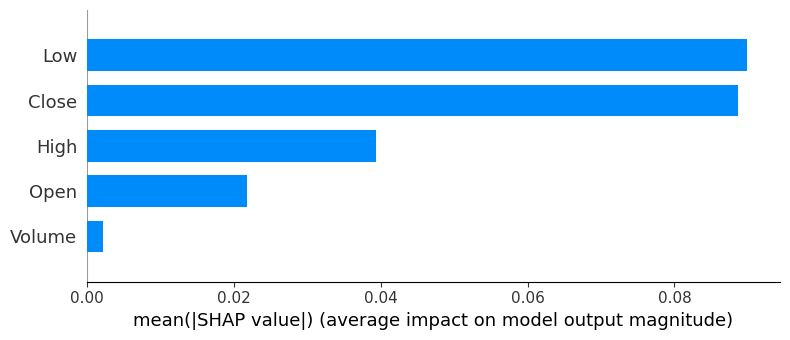

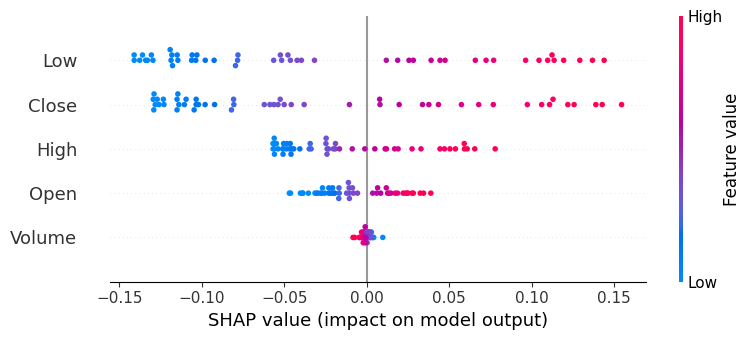

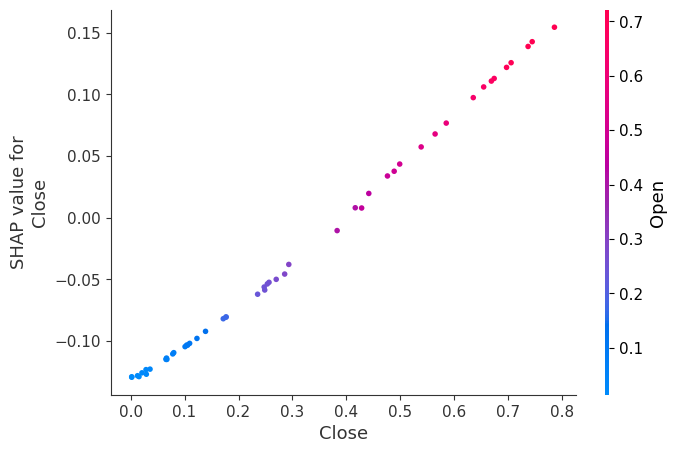

In [ ]:
import shap
import matplotlib.pyplot as plt


X_train_agg = np.mean(X_train, axis=1)   # (n, 5)
X_test_agg  = np.mean(X_test, axis=1)    # (n, 5)

# Prediction wrapper for SHAP
def model_predict(x):
    # Repeat features across timesteps → (n, 60, 5)
    x_seq = np.repeat(x[:, np.newaxis, :], SEQ_LEN, axis=1)
    return model.predict(x_seq, verbose=0)

# Background & explain sets
X_background = X_train_agg[:30]
X_explain    = X_test_agg[:50]


explainer = shap.KernelExplainer(model_predict, X_background)
shap_values = explainer.shap_values(X_explain, nsamples=100)


if isinstance(shap_values, list):
    shap_values = shap_values[0]


if shap_values.ndim == 3 and shap_values.shape[-1] == 1:
    shap_values = np.squeeze(shap_values, axis=-1)


shap_values = np.array(shap_values)   # (50, 5)
print("✅ shap_values shape:", shap_values.shape)
print("✅ X_explain shape:", X_explain.shape)


shap.summary_plot(shap_values, X_explain, feature_names=FEATURES, plot_type="bar")
shap.summary_plot(shap_values, X_explain, feature_names=FEATURES)


# Step 4: SHAP Dependency Plot

shap.dependence_plot("Close", shap_values, X_explain, feature_names=FEATURES)


# Step 5: SHAP Force Plot (single prediction)

shap.initjs()
idx = 5  # choose any test sample
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_explain[idx],
    feature_names=FEATURES
)

  0%|          | 0/50 [00:00<?, ?it/s]

✅ shap_values shape: (50, 5)
✅ X_explain shape: (50, 5)


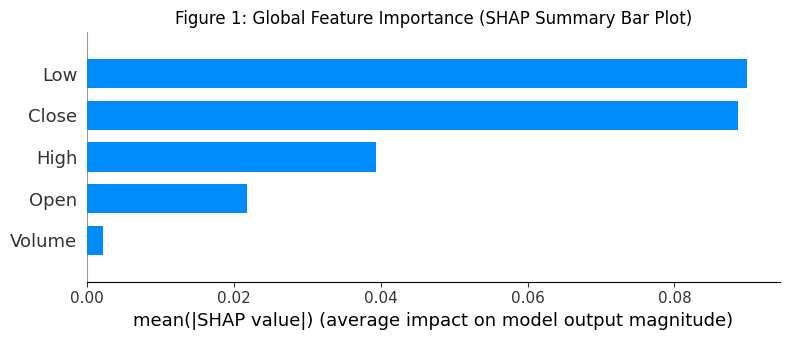

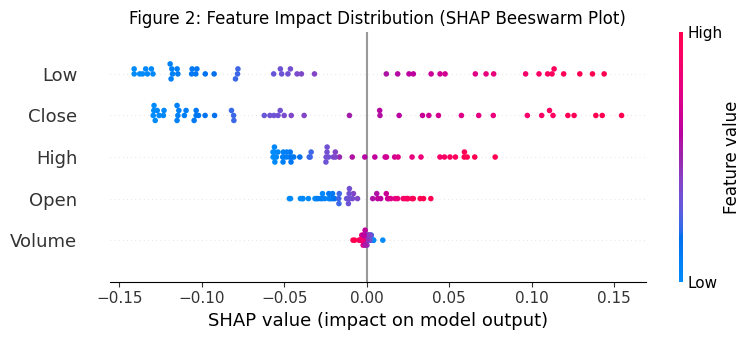

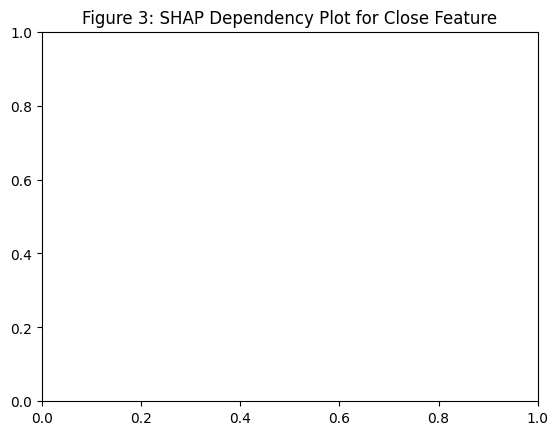

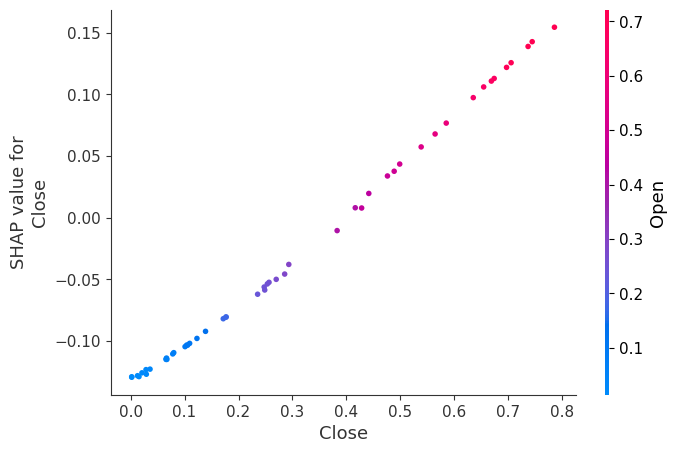

In [ ]:
import shap
import matplotlib.pyplot as plt


# Step 1: Aggregate inputs (mean across timesteps → 5 features)

X_train_agg = np.mean(X_train, axis=1)   # (n, 5)
X_test_agg  = np.mean(X_test, axis=1)    # (n, 5)


def model_predict(x):
    # Repeat features across timesteps → (n, 60, 5)
    x_seq = np.repeat(x[:, np.newaxis, :], SEQ_LEN, axis=1)
    return model.predict(x_seq, verbose=0)


X_background = X_train_agg[:30]
X_explain    = X_test_agg[:50]


# Step 2: KernelExplainer

explainer = shap.KernelExplainer(model_predict, X_background)
shap_values = explainer.shap_values(X_explain, nsamples=100)


if isinstance(shap_values, list):
    shap_values = shap_values[0]


if shap_values.ndim == 3 and shap_values.shape[-1] == 1:
    shap_values = np.squeeze(shap_values, axis=-1)


shap_values = np.array(shap_values)   # (50, 5)
print("✅ shap_values shape:", shap_values.shape)
print("✅ X_explain shape:", X_explain.shape)


# Step 3: SHAP Summary Plots



plt.title("Figure 1: Global Feature Importance (SHAP Summary Bar Plot)")
shap.summary_plot(shap_values, X_explain, feature_names=FEATURES, plot_type="bar", show=False)
plt.show()

# Beeswarm summary plot (distribution of feature impacts)
plt.title("Figure 2: Feature Impact Distribution (SHAP Beeswarm Plot)")
shap.summary_plot(shap_values, X_explain, feature_names=FEATURES, show=False)
plt.show()


# Step 4: SHAP Dependency Plot

plt.title("Figure 3: SHAP Dependency Plot for Close Feature")
shap.dependence_plot("Close", shap_values, X_explain, feature_names=FEATURES, show=False)
plt.show()


# Step 5: SHAP Force Plot (local explanation)

shap.initjs()
idx = 5  # choose any test sample
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_explain[idx],
    feature_names=FEATURES
)
# Note: Force plot opens interactively in notebook, not as static figure


  0%|          | 0/50 [00:00<?, ?it/s]

✅ shap_values shape: (50, 5)
✅ X_explain shape: (50, 5)


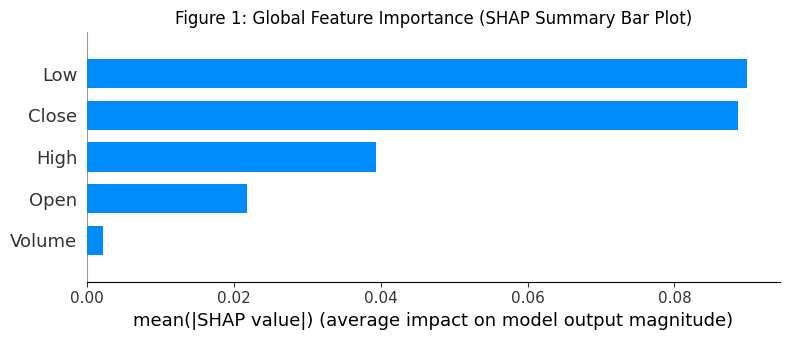

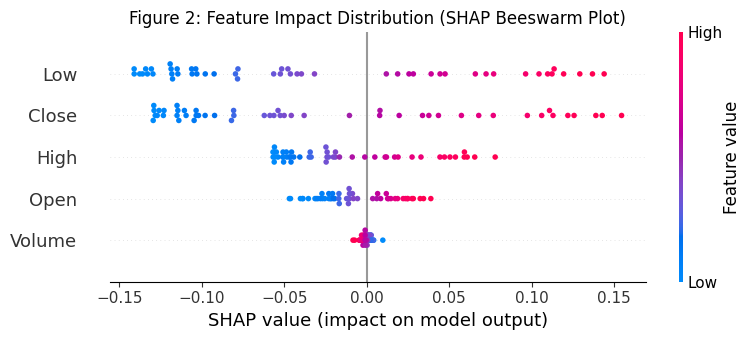

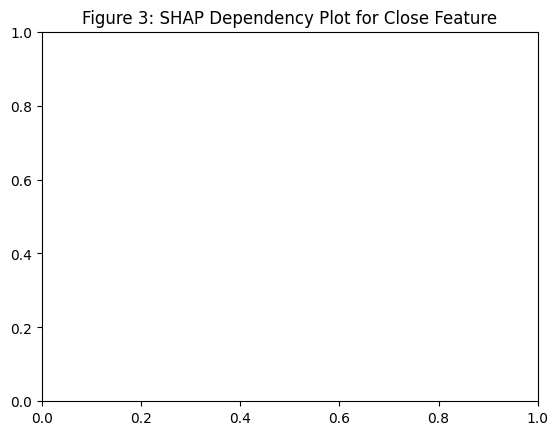

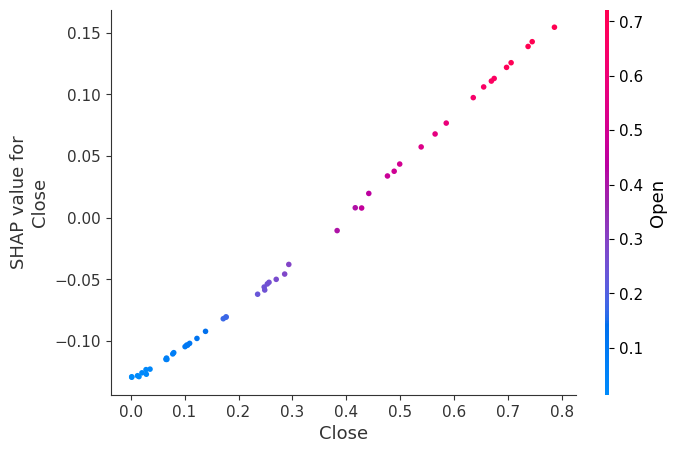

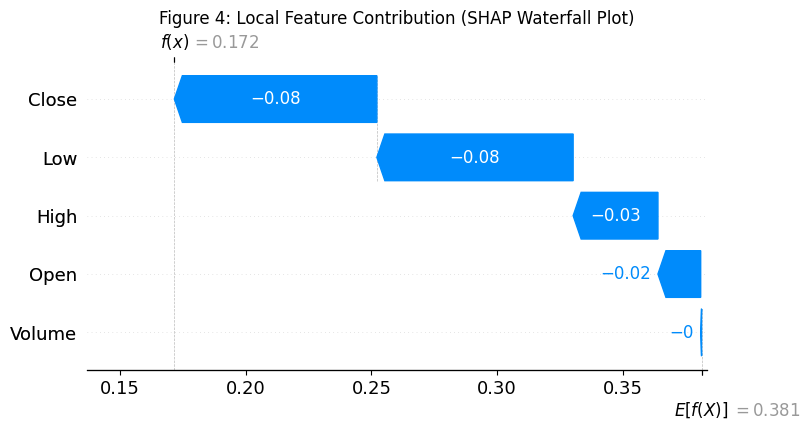

In [ ]:
import shap
import matplotlib.pyplot as plt


X_train_agg = np.mean(X_train, axis=1)   # (n, 5)
X_test_agg  = np.mean(X_test, axis=1)    # (n, 5)

# Prediction wrapper for SHAP
def model_predict(x):
    # Repeat features across timesteps → (n, 60, 5)
    x_seq = np.repeat(x[:, np.newaxis, :], SEQ_LEN, axis=1)
    return model.predict(x_seq, verbose=0)


X_background = X_train_agg[:30]
X_explain    = X_test_agg[:50]

explainer = shap.KernelExplainer(model_predict, X_background)
shap_values = explainer.shap_values(X_explain, nsamples=100)

# Flatten/shapes for plotting
if isinstance(shap_values, list):
    shap_values = shap_values[0]

if shap_values.ndim == 3 and shap_values.shape[-1] == 1:
    shap_values = np.squeeze(shap_values, axis=-1)

shap_values = np.array(shap_values)   # (50, 5)
print("✅ shap_values shape:", shap_values.shape)
print("✅ X_explain shape:", X_explain.shape)


# Bar summary plot (global importance)
plt.title("Figure 1: Global Feature Importance (SHAP Summary Bar Plot)")
shap.summary_plot(shap_values, X_explain, feature_names=FEATURES, plot_type="bar", show=False)
plt.show()

# Beeswarm summary plot (distribution of feature impacts)
plt.title("Figure 2: Feature Impact Distribution (SHAP Beeswarm Plot)")
shap.summary_plot(shap_values, X_explain, feature_names=FEATURES, show=False)
plt.show()


# Step 4: SHAP Dependency Plot

plt.title("Figure 3: SHAP Dependency Plot for Close Feature")
shap.dependence_plot("Close", shap_values, X_explain, feature_names=FEATURES, show=False)
plt.show()


# Step 5: SHAP Waterfall Plot (static, replaces force plot)

idx = 5  # pick one test sample
plt.title("Figure 4: Local Feature Contribution (SHAP Waterfall Plot)")

expected_value = explainer.expected_value[0] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

shap.plots._waterfall.waterfall_legacy(
    expected_value,
    shap_values[idx],
    feature_names=FEATURES
)
plt.show()


Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 54s 207ms/step - loss: 0.0257 - mae: 0.1142 - val_loss: 0.0066 - val_mae: 0.0620
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 218ms/step - loss: 0.0073 - mae: 0.0654 - val_loss: 0.0040 - val_mae: 0.0455
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 216ms/step - loss: 0.0062 - mae: 0.0595 - val_loss: 0.0032 - val_mae: 0.0408
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 47s 208ms/step - loss: 0.0052 - mae: 0.0545 - val_loss: 0.0028 - val_mae: 0.0374
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 49s 217ms/step - loss: 0.0051 - mae: 0.0537 - val_loss: 0.0028 - val_mae: 0.0368
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 80s 207ms/step - loss: 0.0050 - mae: 0.0528 - val_loss: 0.0031 - val_mae: 0.0398
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 83s 210ms/step - loss: 0.0048 - mae: 0.0514 - val_loss: 0.0030 - val_mae: 0.0383
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 84s 218ms/step - loss: 0.0045 - mae: 0.0504 - val_loss: 0.0030 - val_mae: 0.0384
Epoch 9/100
228/228 ━━━━

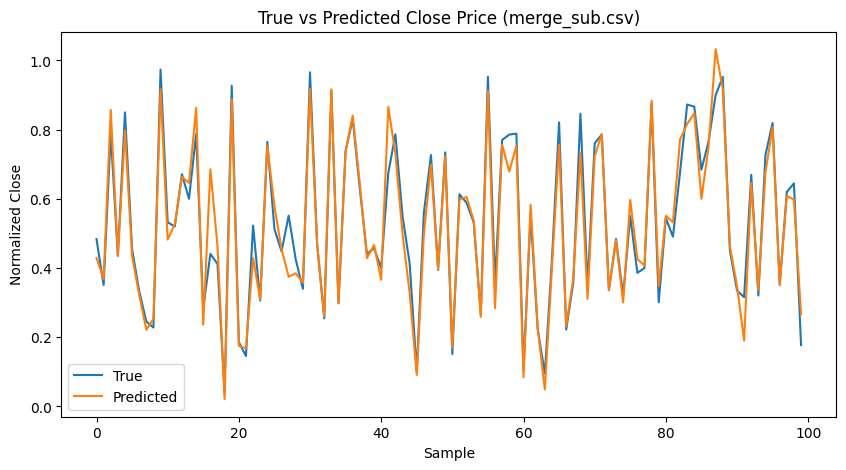

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, Add, BatchNormalization, Dropout, LSTM, MultiHeadAttention, LayerNormalization, Conv1DTranspose
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("/content/drive/MyDrive/Time series/ohlc2.csv")


df["Volume"] = df["Vol"].str.replace(",", "").astype(float)


df = df.rename(columns={"Symbol": "Ticker"})

SEQ_LEN = 60
FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']
TARGET = 'Close'


def create_sequences(df, seq_len=60):
    X, y = [], []
    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values("Date")
        values = group[FEATURES].values
        if len(values) <= seq_len:
            continue
        scaler = MinMaxScaler()
        values_scaled = scaler.fit_transform(values)
        for i in range(len(values_scaled) - seq_len):
            X.append(values_scaled[i:i+seq_len])
            y.append(values_scaled[i+seq_len][FEATURES.index(TARGET)])
    return np.array(X), np.array(y).reshape(-1, 1)

X_all, y_all = create_sequences(df, seq_len=SEQ_LEN)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

def residual_cnn_block(inputs):
    x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(inputs)
    x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    shortcut = Conv1D(filters=64, kernel_size=1, padding="same")(inputs)
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)
    return x

def transformer_block(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn = Dropout(dropout)(attn)
    out1 = Add()([attn, inputs])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    ffn = Dense(ff_dim, activation='relu')(out1)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)
    out2 = Add()([ffn, out1])
    return LayerNormalization(epsilon=1e-6)(out2)

def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = residual_cnn_block(inputs)
    x = transformer_block(x)
    x = LSTM(64)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse", metrics=["mae"])
    return model

model = build_model(X_train.shape[1:])
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

direction_true = np.sign(y_test[1:] - y_test[:-1])
direction_pred = np.sign(y_pred[1:] - y_pred[:-1])
directional_accuracy = np.mean(direction_true == direction_pred) * 100

print(f"\n--- Evaluation Metrics ---")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label="True")
plt.plot(y_pred[:100], label="Predicted")
plt.title("True vs Predicted Close Price (merge_sub.csv)")
plt.xlabel("Sample")
plt.ylabel("Normalized Close")
plt.legend()
plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

✅ shap_values shape: (50, 5)
✅ X_explain shape: (50, 5)


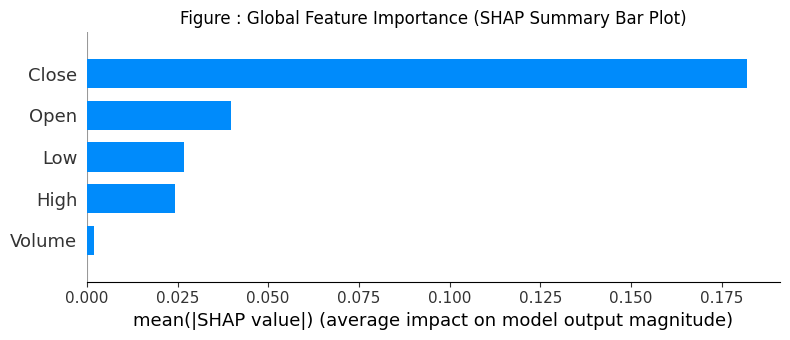

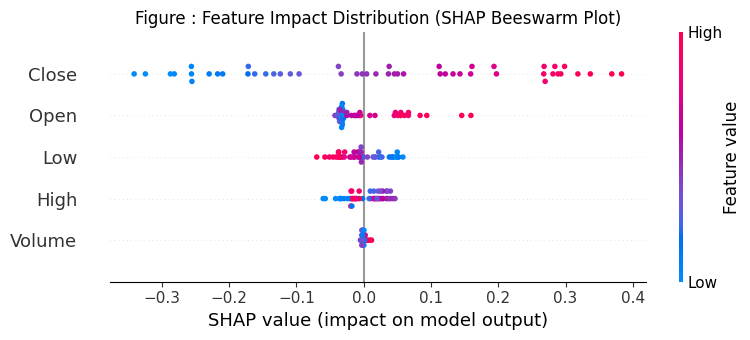

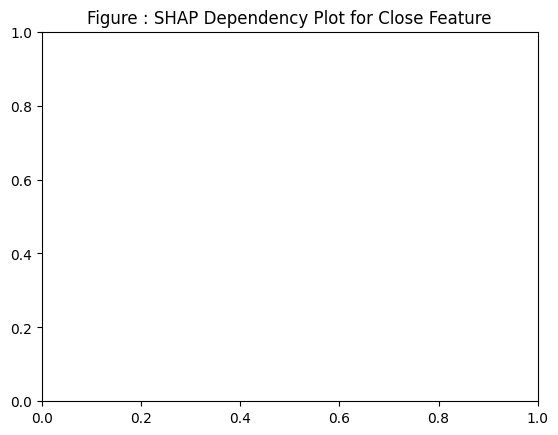

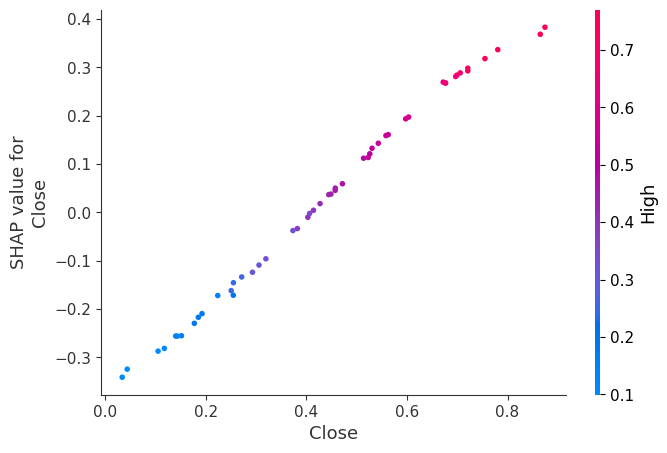

Figure : force plot for sample index 5


In [ ]:
import shap
import matplotlib.pyplot as plt


X_train_agg = np.mean(X_train, axis=1)   # (n, 5)
X_test_agg  = np.mean(X_test, axis=1)    # (n, 5)

def model_predict(x):
    # Repeat features across timesteps → (n, 60, 5)
    x_seq = np.repeat(x[:, np.newaxis, :], SEQ_LEN, axis=1)
    return model.predict(x_seq, verbose=0)

X_background = X_train_agg[:30]
X_explain    = X_test_agg[:50]

explainer = shap.KernelExplainer(model_predict, X_background)
shap_values = explainer.shap_values(X_explain, nsamples=100)

# If SHAP returns a list → take the first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]


if shap_values.ndim == 3 and shap_values.shape[-1] == 1:
    shap_values = np.squeeze(shap_values, axis=-1)


shap_values = np.array(shap_values)   # (50, 5)
print("✅ shap_values shape:", shap_values.shape)
print("✅ X_explain shape:", X_explain.shape)



# Bar summary plot (global importance)
plt.title("Figure : Global Feature Importance (SHAP Summary Bar Plot)")
shap.summary_plot(shap_values, X_explain, feature_names=FEATURES, plot_type="bar", show=False)
plt.show()

# Beeswarm summary plot (distribution of feature impacts)
plt.title("Figure : Feature Impact Distribution (SHAP Beeswarm Plot)")
shap.summary_plot(shap_values, X_explain, feature_names=FEATURES, show=False)
plt.show()


# Step 4: SHAP Dependency Plot

plt.title("Figure : SHAP Dependency Plot for Close Feature")
shap.dependence_plot("Close", shap_values, X_explain, feature_names=FEATURES, show=False)
plt.show()


# Step 5: SHAP Force Plot (local explanation)

shap.initjs()
idx = 5  # choose any test sample
print(f"Figure : force plot for sample index {idx}")
shap.force_plot(
    explainer.expected_value if not isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value[0],
    shap_values[idx],
    X_explain[idx],
    feature_names=FEATURES
)



  0%|          | 0/50 [00:00<?, ?it/s]

✅ shap_values shape: (50, 5)
✅ X_explain shape: (50, 5)


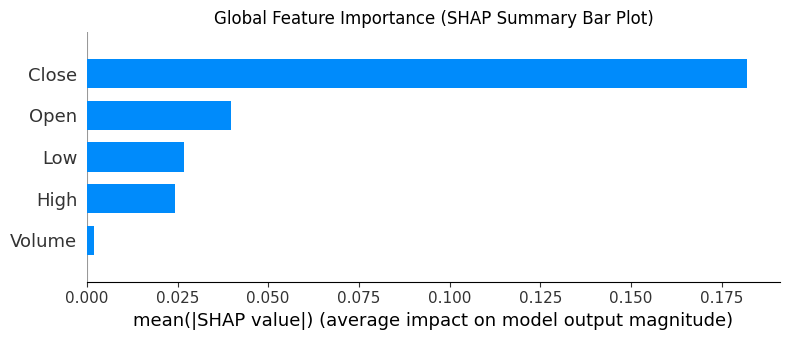

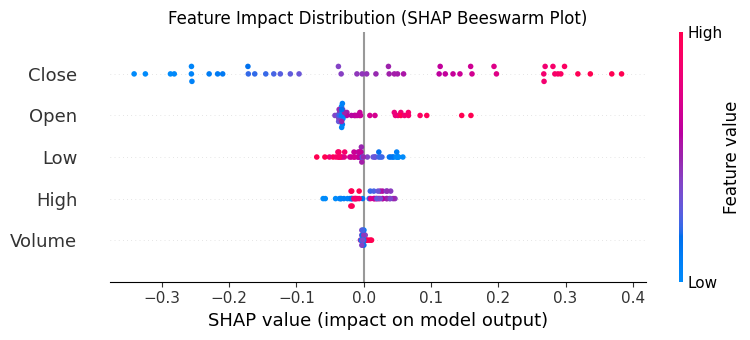

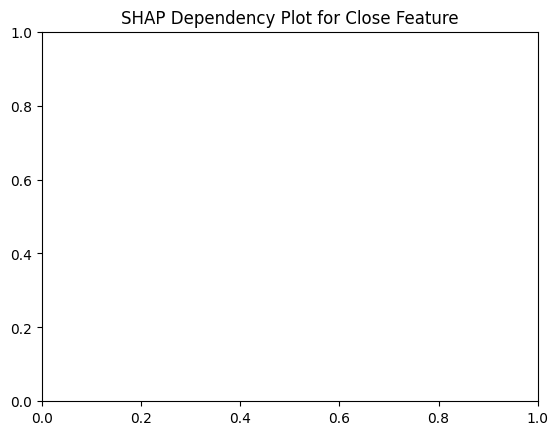

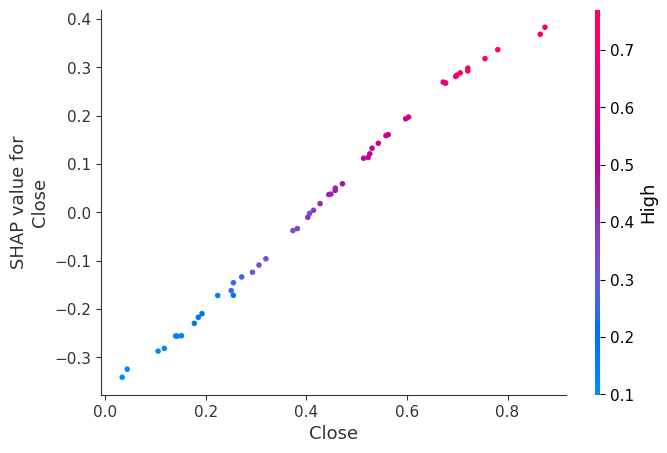

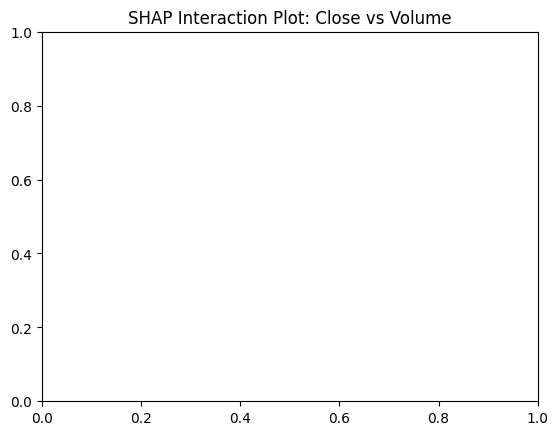

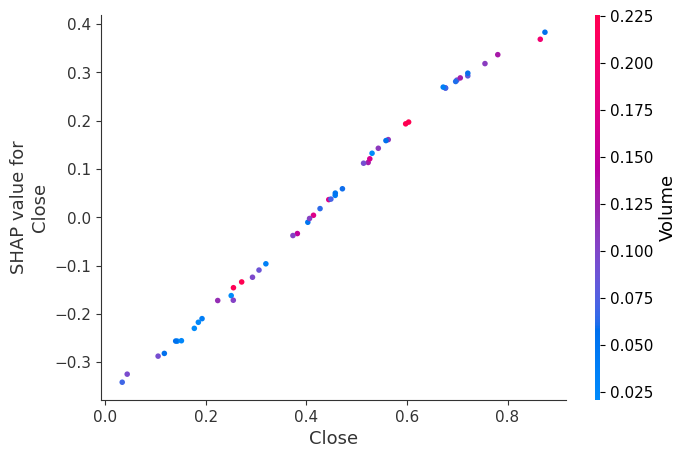

Showing force plot for sample index 5


In [ ]:
import shap
import matplotlib.pyplot as plt


X_train_agg = np.mean(X_train, axis=1)   # (n, 5)
X_test_agg  = np.mean(X_test, axis=1)    # (n, 5)


def model_predict(x):
    # Repeat features across timesteps → (n, 60, 5)
    x_seq = np.repeat(x[:, np.newaxis, :], SEQ_LEN, axis=1)
    return model.predict(x_seq, verbose=0)

X_background = X_train_agg[:30]
X_explain    = X_test_agg[:50]


explainer = shap.KernelExplainer(model_predict, X_background)
shap_values = explainer.shap_values(X_explain, nsamples=100)


if isinstance(shap_values, list):
    shap_values = shap_values[0]

# If extra dimension exists (like (50,5,1)) → squeeze it
if shap_values.ndim == 3 and shap_values.shape[-1] == 1:
    shap_values = np.squeeze(shap_values, axis=-1)


shap_values = np.array(shap_values)   # (50, 5)
print("✅ shap_values shape:", shap_values.shape)
print("✅ X_explain shape:", X_explain.shape)

# Step 3: SHAP Summary Plots


plt.title("Global Feature Importance (SHAP Summary Bar Plot)")
shap.summary_plot(shap_values, X_explain, feature_names=FEATURES, plot_type="bar", show=False)
plt.show()

plt.title("Feature Impact Distribution (SHAP Beeswarm Plot)")
shap.summary_plot(shap_values, X_explain, feature_names=FEATURES, show=False)
plt.show()


# Step 4: SHAP Dependency Plot

plt.title("SHAP Dependency Plot for Close Feature")
shap.dependence_plot("Close", shap_values, X_explain, feature_names=FEATURES, show=False)
plt.show()


# Step 5: SHAP Interaction Plot

plt.title("SHAP Interaction Plot: Close vs Volume")
shap.dependence_plot(
    "Close",
    shap_values,
    X_explain,
    feature_names=FEATURES,
    interaction_index="Volume",
    show=False
)
plt.show()



# Step 6: SHAP Force Plot (local explanation)

shap.initjs()
idx = 5  # choose any test sample
print(f"Showing force plot for sample index {idx}")
shap.force_plot(
    explainer.expected_value if not isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value[0],
    shap_values[idx],
    X_explain[idx],
    feature_names=FEATURES
)
